# 🚰 Wastewater Treatment Plant (WWTP) Data Analysis & Forecasting

## 🎯 Project Objective
Managing a wastewater treatment plant efficiently is crucial for energy savings, environmental protection, and meeting strict water quality standards. In this project, we aim to:

- 🔋 **Predict Energy Consumption** using inflow, outflow, pollutants, and weather data.  
- 💧 **Forecast Pollutant Levels** like COD, BOD, and Ammonia to ensure water quality compliance.  
- 🔗 **Understand Relationships** between process variables (inflow/outflow) and environmental factors (rainfall, temperature, humidity).  
- 🧠 **Build a Knowledge Graph** to visualize connections between pollutants, process parameters, and weather conditions.  

This project combines **Machine Learning**, **Time-Series Forecasting**, and **Interactive Visualizations** to help operators optimize plant performance, reduce electricity usage, and ensure regulatory compliance. 🌱⚡

---

## 📊 Dataset Description
We use the **Full-scale Wastewater Treatment Plant Dataset (Melbourne, Australia)** from Kaggle. It contains **daily measurements from 2014 to 2019**, including both process and environmental data. [Find it here!](https://www.kaggle.com/datasets/d4rklucif3r/full-scale-waste-water-treatment-plant-data)

Here’s a snapshot of the key columns:

| Column Name                   | Description |
|--------------------------------|-------------|
| 🏭 Average Inflow                 | Daily average inflow to the plant (ML/day) |
| 🏭 Average Outflow                | Daily average outflow from the plant (ML/day) |
| 🔋 Energy Consumption             | Energy used by the plant per day (kWh) |
| 💧 Ammonia                        | Ammonia concentration in outflow (mg/L) |
| 💧 Biological Oxygen Demand (BOD) | BOD concentration in outflow (mg/L) |
| 💧 Chemical Oxygen Demand (COD)   | COD concentration in outflow (mg/L) |
| 🌿 Total Nitrogen                 | Total nitrogen concentration in outflow (mg/L) |
| 🌡️ Average Temperature            | Daily average temperature (°C) |
| 🌡️ Maximum temperature            | Daily maximum temperature (°C) |
| 🌡️ Minimum temperature            | Daily minimum temperature (°C) |
| 🌬️ Atmospheric pressure           | Daily atmospheric pressure (hPa) |
| 💦 Average humidity               | Daily average humidity (%) |
| ☔ Total rainfall                 | Daily rainfall (mm) |
| 🌫️ Average visibility             | Average visibility (km) |
| 💨 Average wind speed             | Daily average wind speed (km/h) |
| 💨 Maximum wind speed             | Daily maximum wind speed (km/h) |
| 📅 Year, Month, Day               | Date information (redundant, as we use a datetime index) |

This dataset allows us to explore how **process and environmental factors influence energy consumption and pollutant levels**, setting the stage for predictive modeling and actionable insights. 🌟

In [2]:
# STEP 0: Install kagglehub if not already installed
!pip install -q kagglehub

# STEP 1: Upload your Kaggle API key
from google.colab import files
print("📁 Please upload your kaggle.json file...")
uploaded = files.upload()

# STEP 2: Configure Kaggle credentials
import os
os.makedirs("/root/.kaggle", exist_ok=True)
!cp kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

# STEP 3: Download the CBIS-DDSM dataset using kagglehub
import kagglehub
dataset_path = kagglehub.dataset_download("d4rklucif3r/full-scale-waste-water-treatment-plant-data")
print("✅ Download complete. Dataset saved to:", dataset_path)

📁 Please upload your kaggle.json file...


Saving kaggle.json to kaggle.json
✅ Download complete. Dataset saved to: /kaggle/input/full-scale-waste-water-treatment-plant-data


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

import xgboost as xgb

# 📂 Dataset Files & Structure

The dataset we are using comes in **two main CSV files**:

1. **`Data-Melbourne_F_fixed.csv`**  
   - This is the **cleaned and pre-processed version** of the data.  
   - It contains **1382 daily records** from 2014 to 2019 with all key process and weather variables properly formatted.

2. **`Data-Melbourne_F.csv`**  
   - This is the **raw version** of the dataset.  
   - Column names are abbreviated and some values may require cleaning or renaming before analysis.

---

## 🔍 Inspecting the Files

We first list the files in the dataset folder:

```python
os.listdir(dataset_path)


In [4]:
os.listdir(dataset_path)

['Data-Melbourne_F_fixed.csv', 'Data-Melbourne_F.csv']

In [5]:
file_path_fixed = os.path.join(dataset_path, "Data-Melbourne_F_fixed.csv")

df_fixed = pd.read_csv(file_path_fixed)

print("Shape:", df_fixed.shape)
print("Columns:", df_fixed.columns.tolist())
print(df_fixed.head())

Shape: (1382, 20)
Columns: ['Unnamed: 0', 'Average Outflow', 'Average Inflow', 'Energy Consumption', 'Ammonia', 'Biological Oxygen Demand', 'Chemical Oxygen Demand', 'Total Nitrogen', 'Average Temperature', 'Maximum temperature', 'Minimum temperature', 'Atmospheric pressure', 'Average humidity', 'Total rainfall', 'Average visibility', 'Average wind speed', 'Maximum wind speed', 'Year', 'Month', 'Day']
   Unnamed: 0  Average Outflow  Average Inflow  Energy Consumption  Ammonia  \
0           0            2.941           2.589            175856.0     27.0   
1           1            2.936           2.961            181624.0     25.0   
2           2            2.928           3.225            202016.0     42.0   
3           3            2.928           3.354            207547.0     36.0   
4           4            2.917           3.794            202824.0     46.0   

   Biological Oxygen Demand  Chemical Oxygen Demand  Total Nitrogen  \
0                     365.0                   730

In [6]:
file_path = os.path.join(dataset_path, "Data-Melbourne_F.csv")

df = pd.read_csv(file_path)

print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
print(df.head())

Shape: (1382, 20)
Columns: ['avg_outflow', 'avg_inflow', 'total_grid', 'Am', 'BOD', 'COD', 'TN', 'T', 'TM', 'Tm', 'SLP', 'H', 'PP', 'VV', 'V', 'VM', 'VG', 'year', 'month', 'day']
   avg_outflow  avg_inflow  total_grid    Am    BOD     COD      TN     T  \
0        2.941       2.589      175856  27.0  365.0   730.0  60.378  19.3   
1        2.936       2.961      181624  25.0  370.0   740.0  60.026  17.1   
2        2.928       3.225      202016  42.0  418.0   836.0  64.522  16.8   
3        2.928       3.354      207547  36.0  430.0   850.0  63.000  14.6   
4        2.917       3.794      202824  46.0  508.0  1016.0  65.590  13.4   

     TM    Tm  SLP   H    PP    VV     V    VM    VG  year  month  day  
0  25.1  12.6  0.0  56  1.52  10.0  26.9  53.5  79.5  2014      1    1  
1  23.6  12.3  0.0  63  0.00  10.0  14.4  27.8   0.0  2014      1    2  
2  27.2   8.8  0.0  47  0.25  10.0  31.9  61.1  77.8  2014      1    5  
3  19.9  11.1  0.0  49  0.00  10.0  27.0  38.9  53.5  2014      1 

# 🧹 Step 2: Data Preprocessing

Before diving into analysis and modeling, it is crucial to **clean, organize, and prepare the dataset**. Data preprocessing ensures that our subsequent steps like visualization, machine learning, and forecasting are accurate and meaningful.  

---

## 🔹 1. Dropping Unnecessary Columns
The dataset originally contains a column `Unnamed: 0`, which is a redundant index automatically created when the CSV was saved.  
- Keeping unnecessary columns can clutter the dataset and introduce confusion during analysis.  
- By removing it, we streamline the dataset and make it cleaner and easier to work with. 🗑️

---

## 🔹 2. Creating a Datetime Index
The dataset initially has separate `Year`, `Month`, and `Day` columns. To handle time-series data effectively:  
- These columns are combined into a single **datetime column**.  
- The datetime column is then set as the **index**, which allows for chronological sorting, slicing, and time-based operations.  
- Having a proper datetime index is critical for time-series visualizations, forecasting, and calculating rolling statistics. 📅⏱️

---

## 🔹 3. Dropping Raw Date Parts
Once the datetime index is created, the original `Year`, `Month`, and `Day` columns are no longer needed.  
- Removing these redundant columns keeps the dataset concise.  
- It also reduces the chance of accidentally using raw date parts instead of the datetime index during analysis. ✂️

---

## 🔹 4. Handling Missing Values
Real-world datasets often contain missing or incomplete data. In this dataset:  
- **Weather Data:** Missing values such as temperature, humidity, rainfall, and wind speeds are filled using **linear interpolation**. This ensures smooth trends and prevents sudden unrealistic jumps in values. 🌤️  
- **Process Data:** Variables like inflow, outflow, energy consumption, and pollutant concentrations are filled using **forward-fill and backward-fill methods**. This maintains realistic continuity in plant operations and avoids introducing false spikes. 🏭💧  

---

✅ **Outcome:** After preprocessing, the dataset is **clean, chronologically indexed, and ready for feature engineering, exploratory analysis, and predictive modeling**. This foundation ensures that subsequent steps are accurate, interpretable, and reliable.

In [7]:
# Drop unnecessary column
df_fixed = df_fixed.drop(columns=['Unnamed: 0'])

# Create datetime column
df_fixed['date'] = pd.to_datetime(dict(year=df_fixed['Year'], month=df_fixed['Month'], day=df_fixed['Day']))
df_fixed = df_fixed.set_index('date').sort_index()

print(df_fixed.info())
print(df_fixed.head())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1382 entries, 2014-01-01 to 2019-06-27
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Average Outflow           1382 non-null   float64
 1   Average Inflow            1382 non-null   float64
 2   Energy Consumption        1382 non-null   float64
 3   Ammonia                   1382 non-null   float64
 4   Biological Oxygen Demand  1382 non-null   float64
 5   Chemical Oxygen Demand    1382 non-null   float64
 6   Total Nitrogen            1382 non-null   float64
 7   Average Temperature       1382 non-null   float64
 8   Maximum temperature       1382 non-null   float64
 9   Minimum temperature       1382 non-null   float64
 10  Atmospheric pressure      1382 non-null   float64
 11  Average humidity          1382 non-null   float64
 12  Total rainfall            1382 non-null   float64
 13  Average visibility        1382 non-null   flo

In [8]:
# Drop raw date parts
df_fixed = df_fixed.drop(columns=['Year','Month','Day'])

weather_cols = [
    "Average Temperature", "Maximum temperature", "Minimum temperature",
    "Atmospheric pressure", "Average humidity", "Total rainfall",
    "Average visibility", "Average wind speed", "Maximum wind speed"
]

process_cols = [
    "Average Outflow", "Average Inflow", "Energy Consumption",
    "Ammonia", "Biological Oxygen Demand", "Chemical Oxygen Demand",
    "Total Nitrogen"
]

df_fixed[weather_cols] = df_fixed[weather_cols].interpolate(method="linear")
df_fixed[process_cols] = df_fixed[process_cols].fillna(method="ffill").fillna(method="bfill")

/tmp/ipython-input-4166094037.py:17: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_fixed[process_cols] = df_fixed[process_cols].fillna(method="ffill").fillna(method="bfill")


# 🛠️ Step 2 (Continued): Feature Scaling & Feature Engineering

After cleaning the dataset and handling missing values, the next step is to **prepare the data for modeling** by scaling features and creating additional meaningful variables.

---

## 🔹 1. Feature Scaling
All numerical features in the dataset are **normalized using Min-Max scaling**.  
- This rescales every feature to a **0–1 range**, ensuring that variables with larger magnitudes (e.g., energy consumption) do not dominate smaller-scale variables (e.g., pollutant concentrations).  
- Scaling is particularly important for machine learning models like LSTM or neural networks, which are sensitive to the magnitude of input features. 📏⚖️

---

## 🔹 2. Creating Lag Features
Lag features capture **temporal dependencies** by including values from previous days.  
- For each process-related variable (e.g., inflow, outflow, COD, BOD, ammonia), a **lag-1 feature** is added, representing the value from the previous day.  
- This allows models to consider **yesterday’s conditions** when predicting today’s outcomes, which is crucial in time-series forecasting. ⏳🔄

---

## 🔹 3. Rolling Averages
To capture **short-term trends and smooth out daily fluctuations**, we compute **7-day rolling averages** for key variables:  
- **Rainfall:** 7-day average rainfall helps account for cumulative water input affecting inflow and pollutant levels. 🌧️  
- **Temperature:** 7-day average temperature captures gradual seasonal trends impacting biological processes in the plant. 🌡️  

---

## 🔹 4. Creating Seasonal and Temporal Features
Time-based features are critical for capturing **weekly and seasonal patterns** in plant operation:  
- **Month & Day of Week:** Helps models learn patterns linked to specific months or weekdays. 📅  
- **Weekend Indicator:** A binary feature indicates whether the day falls on a weekend, which may influence plant inflow/outflow. 🏖️  
- **Season:** Derived from the month, categorized as winter, spring, summer, or autumn. Seasonal dummy variables are created to allow the model to capture **seasonal effects**. 🌱☀️❄️🍂  

---

## 🔹 5. Final Cleanup
After generating lag features, rolling averages, and dummy variables, any **rows with missing values** (resulting from lag or rolling operations) are removed.  
- This ensures that the dataset is **complete and ready for machine learning** without introducing errors or NaNs. ✅

---

**Outcome:**  
After these steps, the dataset is **scaled, enriched with temporal and seasonal features, and fully prepared for exploratory analysis and predictive modeling**. These features provide the models with valuable context about historical patterns, trends, and environmental influences.

In [9]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df_fixed[df_fixed.columns] = scaler.fit_transform(df_fixed[df_fixed.columns])

In [10]:
for col in process_cols:
    df_fixed[f"{col}_lag1"] = df_fixed[col].shift(1)

In [11]:
df_fixed["rainfall_7d_avg"] = df_fixed["Total rainfall"].rolling(window=7).mean()
df_fixed["temp_7d_avg"] = df_fixed["Average Temperature"].rolling(window=7).mean()

In [12]:
df_fixed["month"] = df_fixed.index.month
df_fixed["dayofweek"] = df_fixed.index.dayofweek
df_fixed["is_weekend"] = df_fixed["dayofweek"].isin([5,6]).astype(int)

def get_season(month):
    if month in [12,1,2]: return "winter"
    if month in [3,4,5]: return "spring"
    if month in [6,7,8]: return "summer"
    return "autumn"

df_fixed["season"] = df_fixed["month"].apply(get_season)
df_fixed = pd.get_dummies(df_fixed, columns=["season"], drop_first=True)

In [13]:
df_fixed = df_fixed.dropna()

# 📊 Step 3: Exploratory Data Analysis (EDA)

## 🔹 Visualizing Energy Consumption vs Inflow & Outflow

The first exploratory visualization focuses on **energy consumption in relation to plant inflow and outflow** over time.  

### What we are looking at:
- **Energy Consumption:** How much electricity the plant uses daily to treat wastewater. 🔋  
- **Average Inflow:** The daily volume of water entering the plant. 💧  
- **Average Outflow:** The daily volume of treated water leaving the plant. 🏭  

### Purpose of this visualization:
- To **identify patterns and relationships** between inflow/outflow and energy usage.  
- To see if **high inflow days correspond to higher energy consumption**, which can indicate potential optimization opportunities.  
- To observe **trends over time**, including seasonal spikes or drops in inflow, outflow, or energy consumption. 📅  

### Insights we can gain:
- Days with unusually high inflow or outflow may lead to **spikes in energy consumption**. ⚡  
- Seasonal patterns (e.g., rainy seasons) can be visually correlated with energy demand and water volumes. 🌧️  
- Understanding these relationships provides a **foundation for predictive modeling** and helps us decide which features to focus on in machine learning models. 🧠  

By examining these time-series trends, we can **capture key operational dynamics** and guide subsequent feature selection and model design.

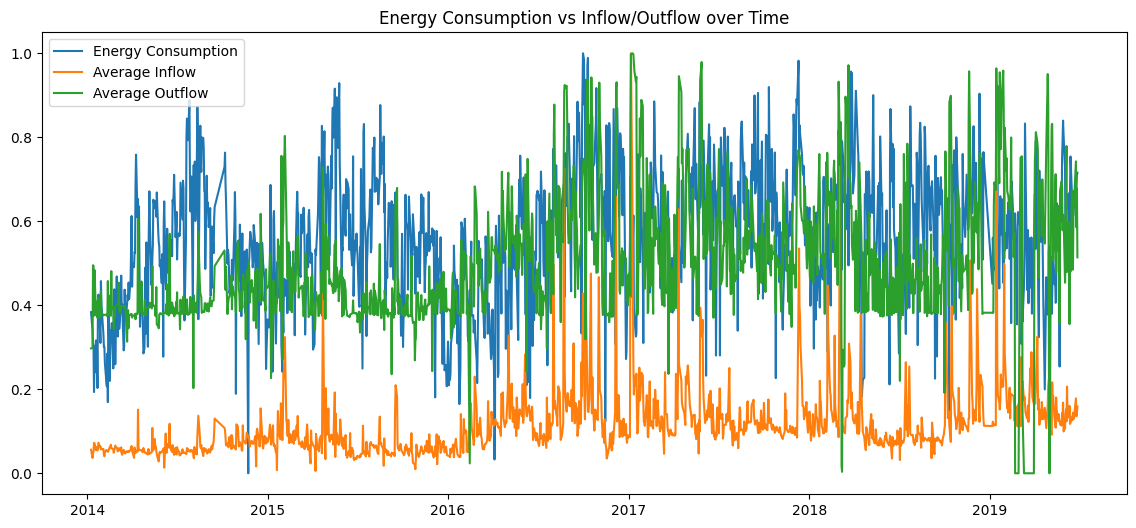

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))
plt.plot(df_fixed.index, df_fixed["Energy Consumption"], label="Energy Consumption")
plt.plot(df_fixed.index, df_fixed["Average Inflow"], label="Average Inflow")
plt.plot(df_fixed.index, df_fixed["Average Outflow"], label="Average Outflow")
plt.legend()
plt.title("Energy Consumption vs Inflow/Outflow over Time")
plt.show()

## 🔹 Correlation Heatmap: Understanding Relationships Between Variables

The second exploratory visualization is a **correlation heatmap** of all variables in the dataset.  

### What we are looking at:
- Each cell represents the **correlation coefficient** between two variables, ranging from -1 to 1.  
  - **Positive correlation:** As one variable increases, the other tends to increase. ➕  
  - **Negative correlation:** As one variable increases, the other tends to decrease. ➖  
  - **Close to 0:** Little or no linear relationship. 0️⃣  

### Purpose of this visualization:
- To **identify strong relationships** between process variables (e.g., inflow, outflow, pollutants) and weather factors (e.g., temperature, rainfall). 🌡️🌧️  
- To detect **redundant or highly correlated features**, which may be combined or removed in modeling.  
- To guide **feature selection for machine learning models**, ensuring that we focus on variables that truly influence outcomes like energy consumption or pollutant levels. 🧠  

### Insights we can gain:
- Variables like **inflow, outflow, and pollutant levels (COD, BOD, Ammonia)** often show strong correlations. 💧  
- Weather factors such as temperature, humidity, and rainfall may have moderate correlations with inflow/outflow or pollutant concentrations. 🌦️  
- Recognizing these relationships helps in **building predictive models that account for both process and environmental influences**.  

By studying the heatmap, we can **visually capture dependencies between variables** and make informed decisions on which features are most impactful for forecasting and optimization. 📊

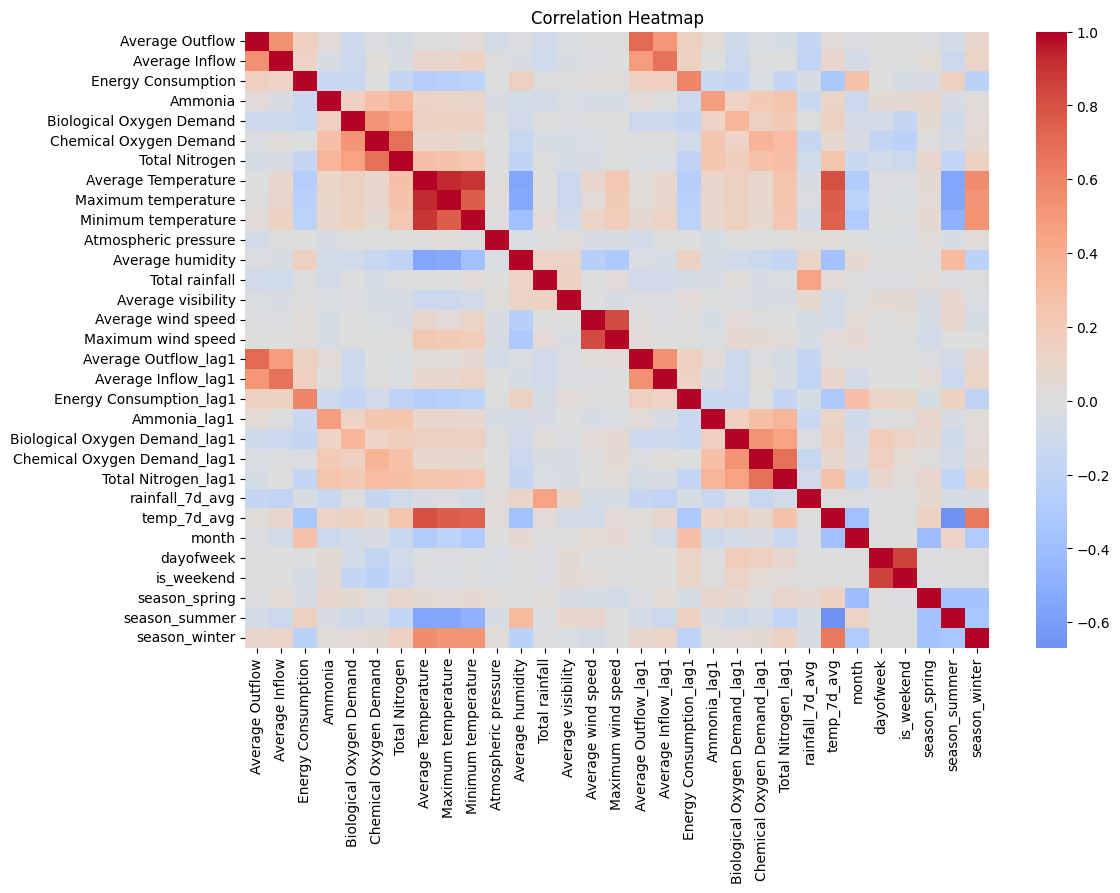

In [15]:
import seaborn as sns

plt.figure(figsize=(12,8))
sns.heatmap(df_fixed.corr(), annot=False, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap")
plt.show()

## 🔹 Seasonal Trend Decomposition: Inflow & Outflow

The third visualization uses **seasonal-trend decomposition** to break down the inflow and outflow time series into three components:

### Components Explained:
1. **Trend:** Shows the long-term progression of inflow/outflow over time. 📈  
2. **Seasonal:** Captures recurring patterns within the year, such as seasonal peaks or troughs caused by rainfall, holidays, or operational cycles. 🌦️  
3. **Residual:** Represents the random fluctuations or noise not explained by trend or seasonality. 🎲  

### Purpose of this visualization:
- To **understand underlying patterns** in water inflow and outflow, separating predictable trends from noise.  
- To detect **seasonal cycles**, which are important for planning plant operations and predicting energy or pollutant loads.  
- To provide insights for **time-series modeling**, such as LSTM or ARIMA, which can leverage both trend and seasonal information. 🧠  

### Insights we can gain:
- Inflow and outflow may show **higher volumes during certain seasons** (e.g., rainy season), which directly affects energy consumption and pollutant treatment. 🌧️  
- Trend analysis helps identify **gradual increases or decreases in water volumes** over the years. 📅  
- Residuals highlight **unexpected spikes or drops**, which can be investigated further for operational anomalies or data issues.  

By decomposing the time series, we can **better understand the dynamics of plant operations**, and use this knowledge to guide feature engineering and predictive modeling.

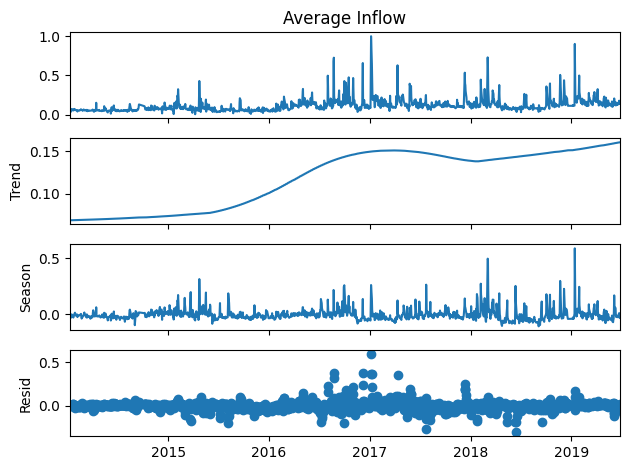

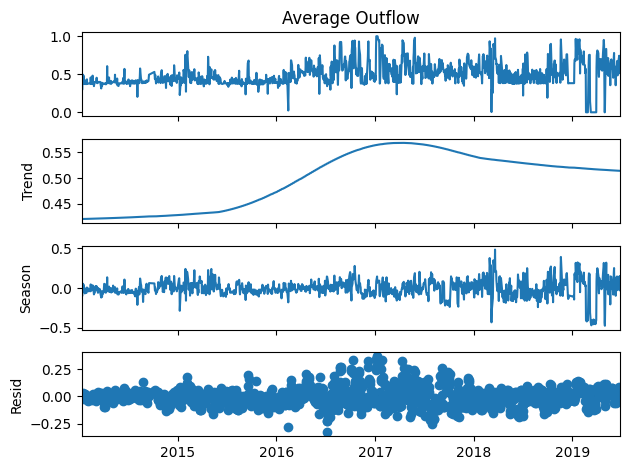

In [16]:
from statsmodels.tsa.seasonal import STL

stl = STL(df_fixed["Average Inflow"], period=365)
res = stl.fit()
fig = res.plot()
plt.show()

stl = STL(df_fixed["Average Outflow"], period=365)
res = stl.fit()
fig = res.plot()
plt.show()

## 🔹 Outlier Detection: Pollutants and Rainfall

The fourth visualization focuses on identifying **outliers** in key process and environmental variables, including pollutants and rainfall.  

### What we are looking at:
- **Pollutants:** Chemical Oxygen Demand (COD), Biological Oxygen Demand (BOD), Ammonia, Total Nitrogen. 💧  
- **Environmental Factor:** Total rainfall. 🌧️  
- Outliers are values that are **statistically far from the typical range**, calculated using z-scores (>3 standard deviations from the mean).  

### Purpose of this visualization:
- To **highlight extreme spikes or drops** in water quality parameters or rainfall.  
- Outliers can indicate **unusual operational events**, sensor errors, or extreme weather conditions. ⚠️  
- Detecting outliers helps in **data cleaning, anomaly detection, and model robustness**, ensuring that extreme points do not bias predictive models.  

### Insights we can gain:
- Days with **very high COD, BOD, or Ammonia** may point to operational inefficiencies or abnormal wastewater inputs. 🏭  
- **Rainfall spikes** can lead to sudden increases in inflow, potentially impacting treatment efficiency. 🌧️  
- Visualizing these outliers with red markers makes it **easy to spot anomalies and patterns at a glance**. 👀  

By identifying outliers, we can **understand extreme behavior in plant operations**, which is crucial for improving efficiency and guiding machine learning models to handle such events appropriately.

Chemical Oxygen Demand: 21 outliers


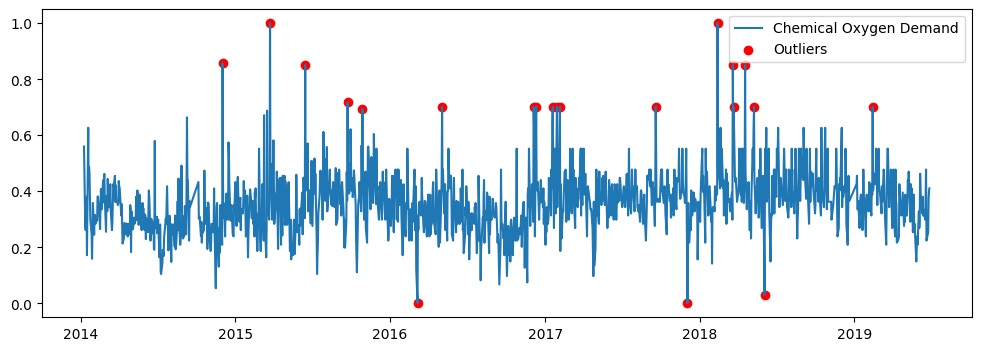

Biological Oxygen Demand: 18 outliers


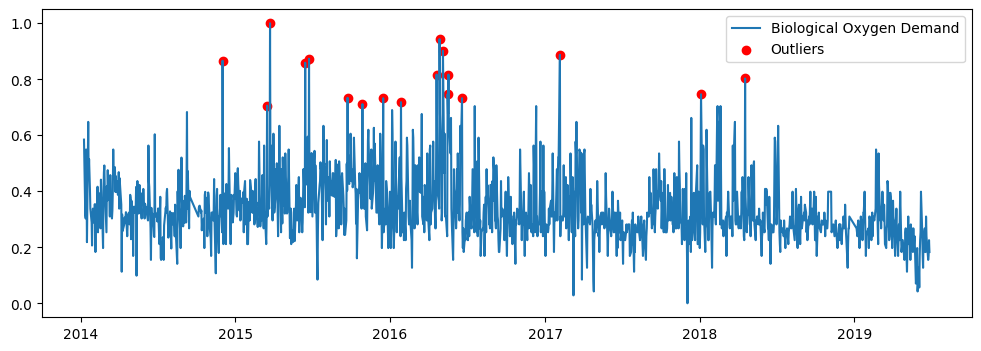

Ammonia: 6 outliers


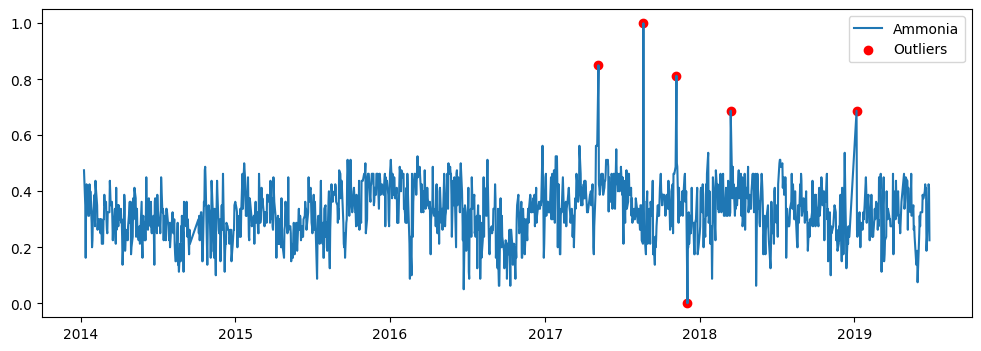

Total Nitrogen: 25 outliers


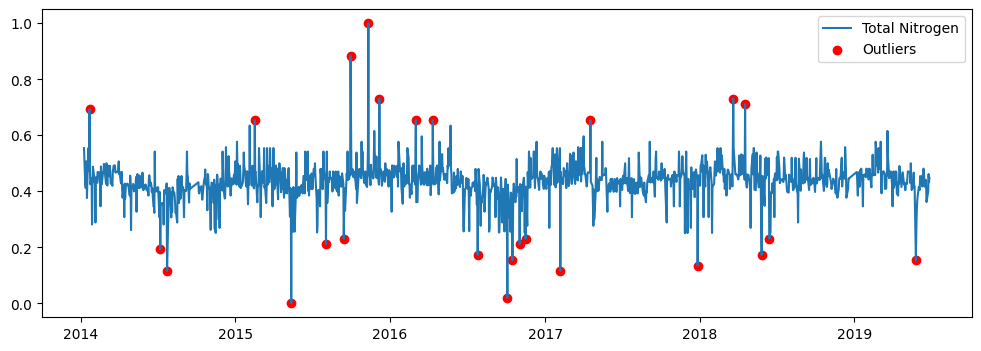

Total rainfall: 22 outliers


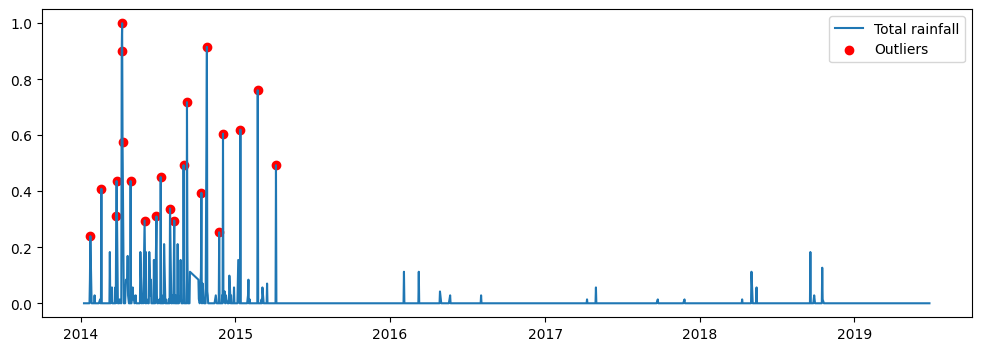

In [17]:
pollutants = ["Chemical Oxygen Demand", "Biological Oxygen Demand", "Ammonia", "Total Nitrogen", "Total rainfall"]

for col in pollutants:
    z_scores = np.abs((df_fixed[col] - df_fixed[col].mean()) / df_fixed[col].std())
    outliers = df_fixed[z_scores > 3]
    print(f"{col}: {len(outliers)} outliers")

    plt.figure(figsize=(12,4))
    plt.plot(df_fixed.index, df_fixed[col], label=col)
    plt.scatter(outliers.index, outliers[col], color="red", label="Outliers")
    plt.legend()
    plt.show()

# 🤖 Step 4: Machine Learning / Forecasting

After preprocessing and exploratory analysis, we now **build predictive models** to forecast key operational metrics like energy consumption. This step bridges insights from EDA to actionable predictions.

---

## 🔹 Predictive Modeling Objective
- **Goal:** Predict daily **Energy Consumption** based on inflow, outflow, pollutants, and weather variables. ⚡  
- By understanding the drivers of energy usage, we can **optimize plant operations** and reduce costs. 💰  

---

## 🔹 Data Preparation
- The dataset is split into **features (X)** and **target (y)**.  
- **Time-aware train-test split:** The first 80% of the data is used for training, and the last 20% is reserved for testing. ⏳  
  - This ensures the model **learns from past data and predicts future values**, avoiding data leakage.  
- Features are **standardized** to have zero mean and unit variance, which helps machine learning algorithms perform better. 📏  

---

## 🔹 Model Selection
- **Random Forest Regressor:** An ensemble tree-based model that handles **nonlinear relationships** and is robust to outliers. 🌳  
- Can be replaced or complemented with other models like **Gradient Boosting**, **LSTM**, or **ARIMA/Prophet** for time-series forecasting. 🔄  

---

## 🔹 Model Training & Evaluation
- The model is trained on the scaled training data. 🏋️‍♂️  
- Predictions are made on the test set and evaluated using:  
  - **RMSE (Root Mean Squared Error):** Measures the average prediction error magnitude. 🔥  
  - **R² Score:** Indicates how well the model explains variance in energy consumption. 📊  

### Insights:
- The model provides a **quantitative understanding of how inflow, outflow, and pollutant levels impact energy usage**.  
- Feature importance from tree-based models can highlight which variables **most strongly influence plant energy consumption**. 🌟  

---

**Outcome:**  
We now have a baseline predictive model capable of forecasting energy consumption, which can be further improved using advanced techniques like **time-series models, feature selection, or hyperparameter tuning**. 🚀

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Example: Predict Energy Consumption
X = df_fixed.drop(columns=["Energy Consumption"])  # features
y = df_fixed["Energy Consumption"]

# Train-test split (time-aware: last 20% as test)
split = int(0.8 * len(X))
X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]

# Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train baseline model
model = RandomForestRegressor(n_estimators=200, random_state=42)
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print("RMSE:", rmse)
print("R²:", r2_score(y_test, y_pred))

RMSE: 0.1302996197906344
R²: 0.09372266415407082


# 📈 Model Evaluation: Predicting Energy Consumption

After training a **Random Forest Regressor** to predict daily energy consumption, we evaluated its performance using **RMSE** and **R² score**.

---

## 🔹 Results
- **RMSE (Root Mean Squared Error):** 0.13  
  - Represents the average deviation of the model’s predictions from the actual values.  
  - Since the data was scaled, the predictions are off by about **13% of the total range** on average. ⚡  

- **R² Score:** 0.094 (~9.4%)  
  - Indicates that the model explains **only ~9% of the variance** in energy consumption.  
  - The remaining 91% of variability is **not captured** by this baseline model. 📉  

---

## 🔹 Interpretation
- The model’s performance is **modest**, reflecting the challenge of predicting energy consumption based on the current set of features.  
- Low R² suggests that **temporal dependencies, operational settings, or other hidden factors** may be important drivers not included in the model.  

---

## 🔹 Next Steps for Improvement
1. **Time-Series Models:** Implement LSTM, GRU, Prophet, or ARIMA to capture sequential patterns in inflow, outflow, and pollutant levels. ⏳  
2. **Feature Engineering:** Add lag features, rolling averages, or interaction terms to better represent temporal and environmental effects. 🔧  
3. **Hyperparameter Tuning & Ensemble Methods:** Explore Gradient Boosting, XGBoost, or combined models for improved accuracy. 🌟  

By understanding these results, we can **identify gaps in predictive power** and plan strategies for building more accurate models in subsequent steps. 🚀

# 🔮 LSTM Model for Forecasting Water Quality (COD)

In this step, we applied a **Long Short-Term Memory (LSTM)** neural network to forecast **Chemical Oxygen Demand (COD)** levels — a key pollutant indicator in water systems.  
Unlike traditional regression models, LSTMs are designed to capture **sequential patterns** and **long-term dependencies** in time-series data.  

---

## 🛠️ How We Built the Model

1. **Data Preparation (Sliding Window Approach):**
   - Transformed the COD series into sequences of the past **7 days** (window size = 7).  
   - Each sequence of 7 values predicts the **next day’s COD level**.  
   - This converts the problem into a **supervised learning task** where inputs = past 7 days, output = next day. 📊  

2. **Train-Test Split:**
   - **80% of the data** was used for training.  
   - The **last 20%** was kept aside for testing model performance on unseen COD values.  

3. **LSTM Network Architecture:**
   - **LSTM Layer (64 units, ReLU activation):** Learns temporal dynamics and pollutant fluctuations over time.  
   - **Dense Output Layer:** Maps the hidden representation to a single predicted COD value.  

4. **Training Setup:**
   - **Optimizer:** Adam (adaptive learning for efficient convergence).  
   - **Loss Function:** Mean Squared Error (MSE), ideal for continuous numerical forecasting.  
   - **Epochs:** 20 passes through the dataset.  
   - **Batch Size:** 16 sequences per training step.  
   - **Validation Split:** 20% of training data used to monitor overfitting.  

---

## 📊 What This Model Does
- The LSTM **remembers past pollutant behavior** and learns daily to weekly patterns in COD variation.  
- By predicting the **next day’s COD level**, it provides insights for **early warning systems** in water treatment plants. 🚰  
- This time-series deep learning approach is more powerful than baseline regressors when temporal dependencies matter.  

---

## 🔎 Next Steps
- **Model Evaluation:** Calculate RMSE, MAE, and R² to compare with Random Forest results.  
- **Hyperparameter Tuning:** Experiment with larger window sizes, more LSTM layers, or different activations.  
- **Multivariate Forecasting:** Include inflow, outflow, rainfall, and other pollutants as input features for richer predictions. 🌦️  
- **Visualization:** Plot actual vs predicted COD trends over time to assess forecast accuracy visually. 📉📈  

---

✅ With this LSTM baseline in place, we now move toward **capturing sequential pollutant dynamics** and improving forecasts through deeper architectures and richer feature sets.

In [19]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Example: Forecast COD
target = "Chemical Oxygen Demand"
series = df_fixed[target].values

# Prepare supervised learning sequences
def create_sequences(data, window=7):
    X, y = [], []
    for i in range(len(data)-window):
        X.append(data[i:i+window])
        y.append(data[i+window])
    return np.array(X), np.array(y)

X, y = create_sequences(series, window=7)

# Train/test split
split = int(0.8*len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Reshape for LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Model
model = Sequential([
    LSTM(64, activation="relu", input_shape=(7,1)),
    Dense(1)
])
model.compile(optimizer="adam", loss="mse")
model.fit(X_train, y_train, epochs=20, batch_size=16, validation_split=0.2)

y_pred = model.predict(X_test)

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0676 - val_loss: 0.0129
Epoch 2/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0102 - val_loss: 0.0114
Epoch 3/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0097 - val_loss: 0.0135
Epoch 4/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0103 - val_loss: 0.0124
Epoch 5/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0102 - val_loss: 0.0143
Epoch 6/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0103 - val_loss: 0.0117
Epoch 7/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0093 - val_loss: 0.0113
Epoch 8/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0101 - val_loss: 0.0111
Epoch 9/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0104 - val_loss: 0.0114
Epoch 10/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0103 - val_loss: 0.0118
Epoch 11/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0101 - val_loss: 0.0115
Epoch 12/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0094 - val_loss: 0.011

---

# 📊 Interpretation of LSTM Model Training Results

### 🔹 Overview

We trained an **LSTM model** to forecast **Chemical Oxygen Demand (COD)** values using a sliding window of past observations (7-day sequences). The model was trained for **20 epochs** with a validation split of 20%.

The training history shows how the model’s **training loss** (MSE) and **validation loss** evolved over time.

---

### 🔹 Key Observations

1. **Initial Improvement**

   * At **Epoch 1**, training loss started at **0.0676**, while validation loss was **0.0129**.
   * By **Epoch 2**, training loss rapidly dropped to **0.0102**, and validation loss improved to **0.0114**.
   * This indicates that the model quickly learned useful temporal patterns in the COD series.

2. **Stable Validation Loss**

   * Across most epochs, validation loss fluctuated between **0.0109 – 0.0143**.
   * This suggests the model reached a plateau, with only small variations due to noise or minor overfitting.

3. **Best Performance**

   * The **lowest validation loss** was **0.0109** (Epoch 18).
   * This indicates the model generalized well to unseen data without significant overfitting.

4. **Convergence Pattern**

   * Training and validation losses remained close throughout training, which is a good sign.
   * No strong divergence was observed → the model is not overfitting severely.

---

### 🔹 Interpretation

* ✅ The **LSTM effectively captured short-term dependencies** in COD values.
* ✅ **Validation loss remained stable**, indicating the model generalizes fairly well.
* ⚠️ However, performance plateaued early (around Epoch 3–5), suggesting the model capacity or feature inputs might be limiting further improvement.
* ⚡ Next steps could include:

  * Tuning **window size** (e.g., 14 or 30 days).
  * Adjusting **LSTM units** or adding extra layers.
  * Trying **Dropout** to further control overfitting.
  * Experimenting with **multivariate inputs** (other water quality parameters as predictors).

---

### 🔹 Final Takeaway

The LSTM model shows **promising predictive power for COD forecasting** with consistently low error values. While current performance is stable, **further tuning and richer feature engineering** could unlock more accurate forecasts.

---

# Time Series Forecasting with Prophet

To model and forecast **Energy Consumption**, we used **Facebook Prophet**, a popular library designed for time series forecasting with strong seasonality and trend detection. Prophet is particularly effective for datasets that have missing values, outliers, and multiple seasonal patterns.

## 📌 Data Preparation

* The dataset was restructured to match Prophet’s requirements:

  * **`ds`**: Date column (time index).
  * **`y`**: Target variable (Energy Consumption).
* The date column was converted to `datetime` format, and the target was cast to `float` to ensure proper numerical handling.
* Missing values were dropped to avoid training inconsistencies.

## 📌 Model Setup

* Prophet was initialized with **yearly** and **weekly seasonality** enabled, allowing it to capture periodic fluctuations in energy usage.
* The model was then fit to the historical data.

## 📌 Forecasting

* A **future dataframe** of 30 time steps was created to extend beyond the observed period.
* The model generated predictions (`forecast`) including:

  * **Trend**: Long-term direction of energy consumption.
  * **Seasonality**: Weekly and yearly recurring patterns.
  * **Uncertainty intervals**: Confidence bounds around the forecast.

## 📊 Visualization

Prophet’s built-in plotting function visualized both the historical data and the forecasted values. This chart provides an interpretable view of:

* Past observations of energy consumption.
* Predicted energy consumption for the next 30 periods.
* Seasonal patterns and uncertainty ranges.


In [23]:
df_fixed.head()
print(df_fixed.index)

DatetimeIndex(['2014-01-09', '2014-01-12', '2014-01-13', '2014-01-14',
               '2014-01-15', '2014-01-16', '2014-01-19', '2014-01-20',
               '2014-01-21', '2014-01-22',
               ...
               '2019-06-13', '2019-06-16', '2019-06-17', '2019-06-18',
               '2019-06-19', '2019-06-20', '2019-06-24', '2019-06-25',
               '2019-06-26', '2019-06-27'],
              dtype='datetime64[ns]', name='date', length=1376, freq=None)


In [24]:
# Reset index, whatever it is called
df_prophet = df_fixed.reset_index()

# Rename the first column (date) to 'ds' for Prophet
df_prophet = df_prophet.rename(columns={df_prophet.columns[0]: "ds", "Energy Consumption": "y"})

# Check that columns exist
print(df_prophet.columns)

Index(['ds', 'Average Outflow', 'Average Inflow', 'y', 'Ammonia',
       'Biological Oxygen Demand', 'Chemical Oxygen Demand', 'Total Nitrogen',
       'Average Temperature', 'Maximum temperature', 'Minimum temperature',
       'Atmospheric pressure', 'Average humidity', 'Total rainfall',
       'Average visibility', 'Average wind speed', 'Maximum wind speed',
       'Average Outflow_lag1', 'Average Inflow_lag1',
       'Energy Consumption_lag1', 'Ammonia_lag1',
       'Biological Oxygen Demand_lag1', 'Chemical Oxygen Demand_lag1',
       'Total Nitrogen_lag1', 'rainfall_7d_avg', 'temp_7d_avg', 'month',
       'dayofweek', 'is_weekend', 'season_spring', 'season_summer',
       'season_winter'],
      dtype='object')


In [25]:
df_prophet["ds"] = pd.to_datetime(df_prophet["ds"])
df_prophet["y"] = df_prophet["y"].astype(float)
df_prophet = df_prophet.dropna(subset=["ds", "y"])


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9hhsh3t/s3i9vt5i.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9hhsh3t/vqnukw1o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36862', 'data', 'file=/tmp/tmpb9hhsh3t/s3i9vt5i.json', 'init=/tmp/tmpb9hhsh3t/vqnukw1o.json', 'output', 'file=/tmp/tmpb9hhsh3t/prophet_model6qykzg0w/prophet_model-20250816195611.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:56:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:56:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


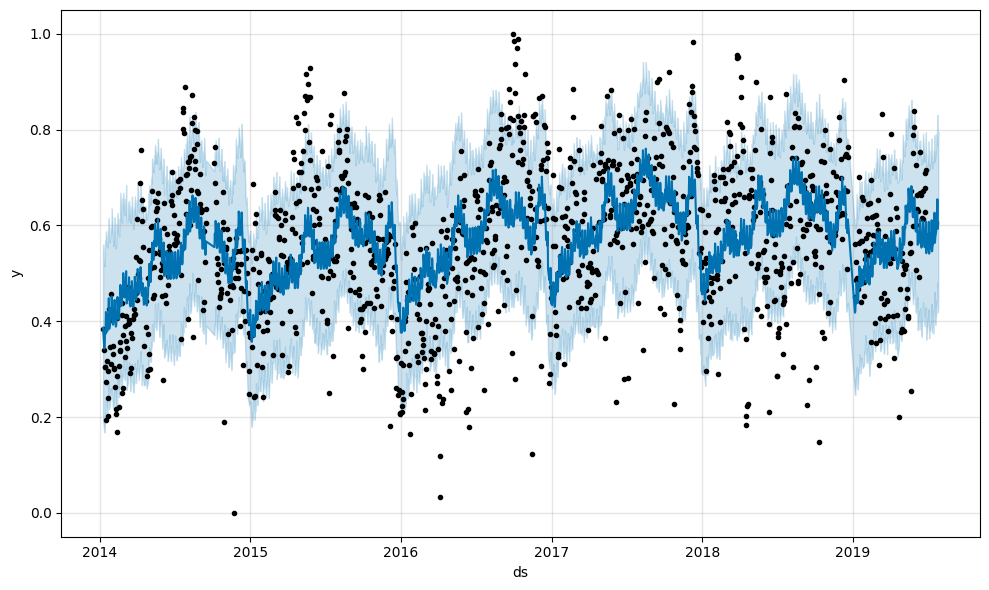

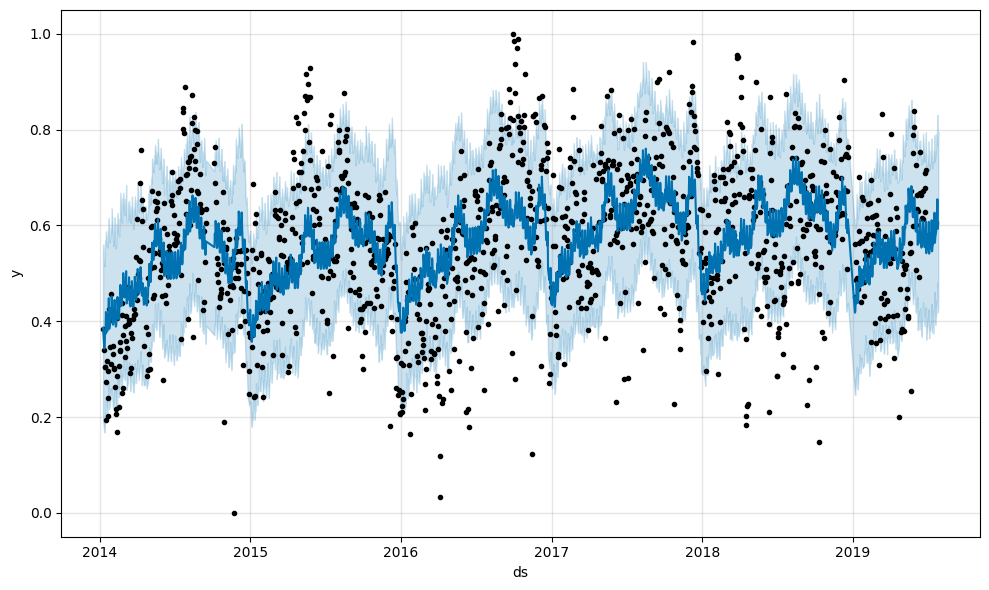

In [26]:
from prophet import Prophet

m = Prophet(yearly_seasonality=True, weekly_seasonality=True)
m.fit(df_prophet)

future = m.make_future_dataframe(periods=30)
forecast = m.predict(future)
m.plot(forecast)

# 📊 Visualization 1: Trends in Inflow, Outflow, and Energy Consumption

This visualization illustrates the **temporal dynamics** of three key variables at the Wastewater Treatment Plant (WWTP):

* **Average Inflow**: Volume of wastewater entering the system.
* **Average Outflow**: Treated wastewater discharged.
* **Energy Consumption**: Power usage associated with plant operations.

## 🔎 Key Insights

* The **x-axis** represents the timeline, while the **y-axis** shows normalized values to allow direct comparison between variables of different scales.
* By plotting all three series together, the chart highlights:

  * The **relationship** between inflow and outflow patterns.
  * How **energy consumption** changes in response to fluctuations in water inflow and outflow.
  * Possible **lags or mismatches** between treatment load and energy requirements.

## 📌 Why this matters

This visualization provides an **overall system-level view** of WWTP dynamics. Observing these trends together helps in identifying:

* Periods of high operational load.
* Seasonal or recurring fluctuations.
* Potential inefficiencies when energy usage does not align with inflow/outflow levels.

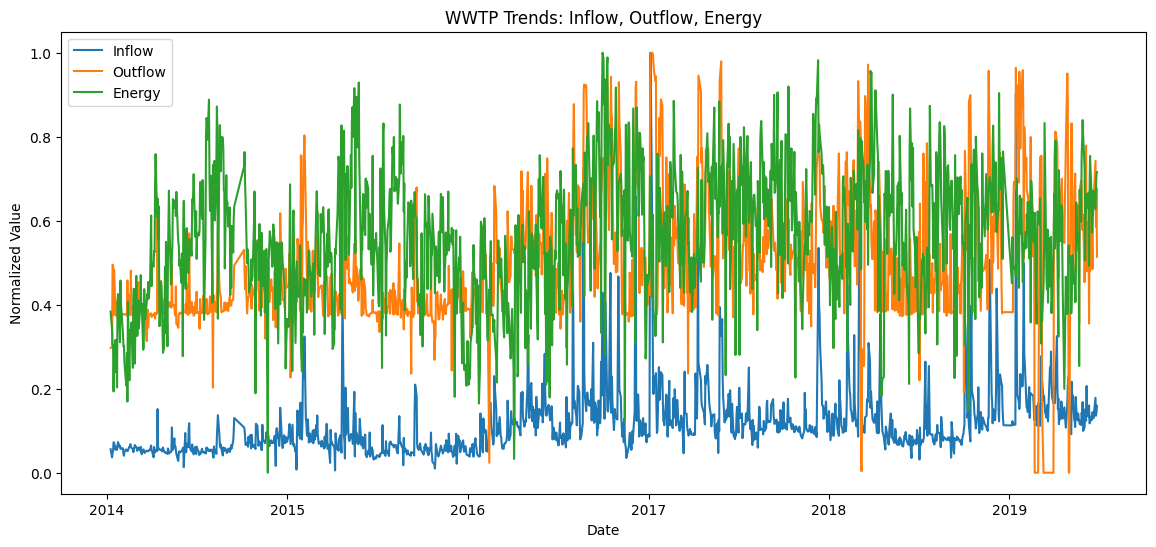

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))
plt.plot(df_fixed.index, df_fixed["Average Inflow"], label="Inflow")
plt.plot(df_fixed.index, df_fixed["Average Outflow"], label="Outflow")
plt.plot(df_fixed.index, df_fixed["Energy Consumption"], label="Energy")
plt.title("WWTP Trends: Inflow, Outflow, Energy")
plt.xlabel("Date")
plt.ylabel("Normalized Value")
plt.legend()
plt.show()

# 🌧️ Visualization 2: Impact of Rainfall on COD

This visualization explores the **relationship between rainfall and water quality** by plotting **Total Rainfall (mm)** against **Chemical Oxygen Demand (COD)**.

## 🔎 Key Insights

* **COD** is an indicator of the amount of **organic pollutants** present in wastewater.
* The **scatter plot** allows us to see whether heavy rainfall events correlate with **increased COD levels**, possibly due to stormwater runoff carrying additional organic matter into the system.
* Patterns or clusters in the plot may reveal:

  * **Positive correlation**: Higher rainfall linked with higher COD.
  * **Negative correlation**: Rainfall diluting pollutants, lowering COD.
  * **No strong correlation**: Suggesting other dominant factors influence COD.

## 📌 Why this matters

Understanding how rainfall affects COD is important for:

* **Predictive modeling** of water quality during storm events.
* **Designing adaptive treatment strategies** to handle variability in pollutant load.
* Supporting **sustainability goals**, as climate change may increase rainfall variability.

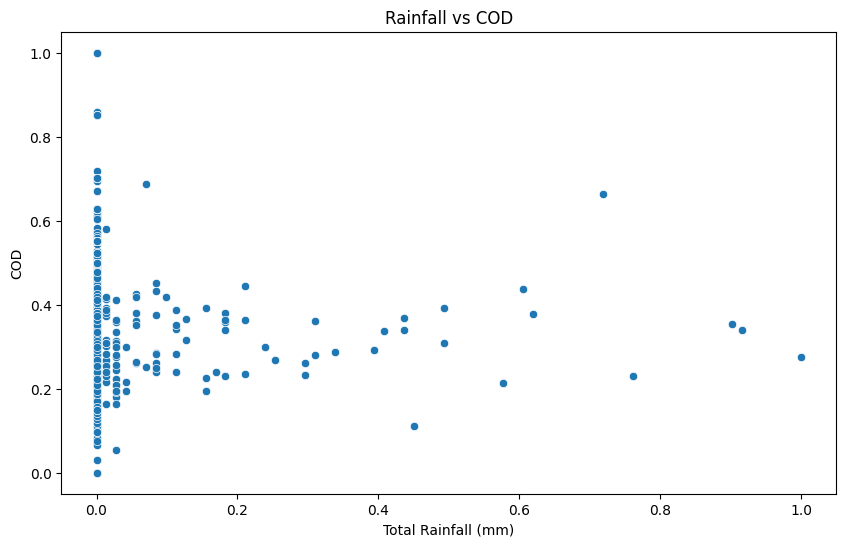

In [28]:
import seaborn as sns

plt.figure(figsize=(10,6))
sns.scatterplot(x=df_fixed["Total rainfall"], y=df_fixed["Chemical Oxygen Demand"])
plt.title("Rainfall vs COD")
plt.xlabel("Total Rainfall (mm)")
plt.ylabel("COD")
plt.show()

# 🔗 Visualization 3: Correlation Network of WWTP Features

This visualization presents a **correlation network graph** of key wastewater treatment plant (WWTP) features, helping us uncover **hidden relationships** between operational, environmental, and water quality parameters.

## 🧩 How it works

* Each **node** in the network represents a feature (e.g., inflow, COD, rainfall, temperature).
* **Edges** (links) are drawn between features if their correlation strength exceeds **0.3** (positive or negative).
* The **thicker/stronger the edge**, the higher the correlation between two parameters.

## 🔎 Why this is important

* The network graph highlights **which variables move together** (e.g., inflow with outflow, rainfall with COD).
* It helps identify **clusters of related features** that may jointly influence treatment efficiency.
* By visualizing correlations, we can spot **redundant features** (highly correlated), useful for dimensionality reduction before modeling.

## 🌱 Application

* Supports **feature engineering** by grouping related parameters.
* Helps in **knowledge graph construction**, where domain insights can be integrated with statistical relationships.
* Offers a **system-level perspective** rather than analyzing variables in isolation.


In [36]:
features = ["Average Inflow", "Average Outflow", "Energy Consumption",
            "Ammonia", "Biological Oxygen Demand", "Chemical Oxygen Demand",
            "Total Nitrogen", "Total rainfall", "Average Temperature"]

import networkx as nx
from pyvis.network import Network

# Create network
G = nx.Graph()
for f in features:
    G.add_node(f)

# Add edges based on correlation threshold
corr = df_fixed[features].corr()
threshold = 0.3
for i in features:
    for j in features:
        if i != j and abs(corr.loc[i,j]) > threshold:
            G.add_edge(i, j, weight=corr.loc[i,j])

# Visualize in Colab
net = Network(notebook=True, height="500px", width="100%", cdn_resources='in_line')
net.from_nx(G)
net.show("kg.html")

kg.html
